<a href="https://colab.research.google.com/github/kkleong17/ADS-assignment/blob/main/ADS2_3rd_assignment_kit_sem_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3 - End-to-End Optimisation

The notebook you have been provided contains code for a convolutional neural network and an image pre-processing and augmentation pipeline. The network and data pipeline are poorly optimised. Your task for this assignment is to analyse the performance of the network, in terms of training speed and the quality of the results, and then make improvements to the network based on your findings.

You will be training the model on the Cats vs Dogs dataset we have previously seen in the tutorials. The pipeline has a preprocessing function that performs some data augmentation. Consider how the pipeline can be made more efficient, use the Tensorboard Profiler tool to help—note you only need to profile a couple of batches, not the full training process.

The CNN uses a VGGNet architechture, built up with blocks of convolutional layers and maxpooling layers. Consider the settings of the existing layers, and whether additional layers can be added to improve the model accuracy, speed up learning, and tackle issues like over fitting. Research decisions around activation functions, optimiser settings.

Train the model as is at least once, and analyse the results—to speed up the notebook for future runs, you can save the weights and reload them to perform analysis. If you do save trhe weights, be sure to download them or store them in your google drive for easy access later on. The initial model could take up to an hour to run, so plan your time ahead.

You should create plots of the loss and metric curves, and to demonstrate the predictive capabilities of the model—think about what types of images the model is getting correct and what it is getting wrong.

You might want to add in callbacks to control modify training, but this isn't strictly necessary. 

(I can't stress enough that this model and pipeline are *bad* and that is deliberate. It should just about learn *something* with no changes, but it won't do a good job. You can change anything in the code below, except for the block that loads the dataset—no training the model on a different set of images.)

# Exercise 1 (10 marks)

Train the network and plot the resulting loss functions and metrics. Create plots that demonstrate the predictive results of the network. Comment on these results in your report. If you are worried about space in your report, you can number your plots inside the notebook and refer to those numbers in the text.

In [ ]:
# Install the tensorflow addons package,
# which has a nice image rotation function
!pip install tensorflow-addons

In [ ]:
# Import modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

import numpy as np

In [ ]:
# Define some Important Variables
IMG_SIZE = (128,128)
BATCH_SIZE = 64
EPOCHS = 20

In [ ]:
# Preprocessing functions. We split the resizing and augmentation so that
# we can apply the augmentation only to the training data
def img_augment(image, label):
    
    # Random left right flip
    image = tf.image.random_flip_left_right(image)
    # Use tensorflow addons to randomly rotate images
    deg = np.random.uniform(-20,20)
    image = tfa.image.rotate(image, deg)
    image = tf.cast(image, 'float32')/255.

    return image, label

def img_resize(image, label):
    # Resize the images
    image = tf.image.resize(image, IMG_SIZE)
    return image, label


In [ ]:
# Load the cats vs dogs dataset

### DONT CHANGE ME ###
train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:80%]", "train[80%:90%]", "train[90%:100%]"],
    as_supervised=True,  # Include labels
)
### DONT CHANGE ME ###

# Set up the datasets with the augmentations and resizing
train_ds = train_ds.map(img_augment).map(img_resize).batch(BATCH_SIZE)
validation_ds = validation_ds.map(img_resize).batch(BATCH_SIZE)
test_ds = test_ds.map(img_resize).batch(BATCH_SIZE)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete76FUIA/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [ ]:
# Sequential Model Definition
def create_model_unoptimised():
    model = Sequential([
    layers.Input(shape=IMG_SIZE+(3,), name='Input'),
    layers.Conv2D(16, 5, padding='same', activation='relu',
                    name='Conv_1'),
    layers.MaxPooling2D(name='Pool_1'),
    layers.Conv2D(32, 4, padding='same', activation='relu', #added a new conv2d
                    name='Conv_2'),
    layers.MaxPooling2D(name='Pool_2'),
    layers.Conv2D(128, 3, padding='same', activation='relu',
                    name='Conv_3'),
    layers.MaxPooling2D(name='Pool_3'),
    layers.Flatten(name='Flatten'),
    layers.Dense(512, activation='relu', name='dense_1'),
    layers.Dense(1, activation='sigmoid', name='Output')
    ], name='CNN')

    return model

In [ ]:
# Create a version of the model and print the summary
model = create_model_unoptimised()

model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_1 (Conv2D)             (None, 128, 128, 16)      1216      
                                                                 
 Pool_1 (MaxPooling2D)       (None, 64, 64, 16)        0         
                                                                 
 Conv_2 (Conv2D)             (None, 64, 64, 32)        8224      
                                                                 
 Pool_2 (MaxPooling2D)       (None, 32, 32, 32)        0         
                                                                 
 Conv_3 (Conv2D)             (None, 32, 32, 128)       36992     
                                                                 
 Pool_3 (MaxPooling2D)       (None, 16, 16, 128)       0         
                                                                 
 Flatten (Flatten)           (None, 32768)             0       

In [ ]:
# Adam optimiser
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
# Binary classification loss
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=False)
# Accuracy metric
metrics = ['accuracy']

# Compile model
model.compile(optimizer=opt,
              loss=loss_obj,
              metrics=metrics)


In [ ]:
# Train the Model


history = model.fit(train_ds,
                    validation_data=validation_ds,
                    epochs=EPOCHS)


Epoch 1/20
291/291 [==============================] - 233s 762ms/step - loss: 0.6391 - accuracy: 0.6222 - val_loss: 159.1463 - val_accuracy: 0.5258
Epoch 2/20
291/291 [==============================] - 222s 761ms/step - loss: 0.5575 - accuracy: 0.7155 - val_loss: 160.7549 - val_accuracy: 0.5400
Epoch 3/20
291/291 [==============================] - 222s 764ms/step - loss: 0.5214 - accuracy: 0.7435 - val_loss: 144.9251 - val_accuracy: 0.5542
Epoch 4/20
291/291 [==============================] - 224s 769ms/step - loss: 0.4915 - accuracy: 0.7629 - val_loss: 157.9488 - val_accuracy: 0.5623
Epoch 5/20
291/291 [==============================] - 223s 765ms/step - loss: 0.4693 - accuracy: 0.7789 - val_loss: 167.4424 - val_accuracy: 0.5658
Epoch 6/20
291/291 [==============================] - 223s 767ms/step - loss: 0.4501 - accuracy: 0.7922 - val_loss: 162.7377 - val_accuracy: 0.5735
Epoch 7/20
291/291 [==============================] - 222s 763ms/step - loss: 0.4327 - accuracy: 0.8035 - val_lo

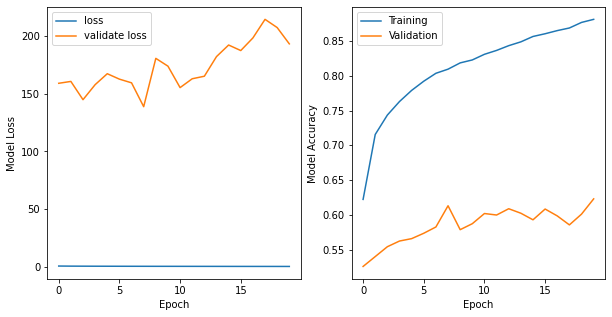

In [ ]:
f, ax = plt.subplots(1,2, figsize = (10,5))

ax[0].plot(history.history['loss'], label = 'loss')
ax[0].plot(history.history['val_loss'], label = 'validate loss') #code taken from tutorial 8 modified
ax[0].set_ylabel('Model Loss')
ax[0].set_xlabel('Epoch')

ax[1].plot(history.history['accuracy'], label = 'Training')
ax[1].plot(history.history['val_accuracy'], label = 'Validation')
ax[1].set_ylabel('Model Accuracy')
ax[1].set_xlabel('Epoch')


ax[0].legend()
plt.legend()
plt.show()

# Exercise 2 (10 marks)
Address the performance issues in the **image processing** pipeline, comment on the choices you make in your report.

You can copy the code above and make changes, or write the piepline from scratch. This could include creating new preprocessing functions.

In [ ]:
def img_augment(image, label):
    
    # Random left right flip
    image = tf.image.random_flip_left_right(image)
    # Use tensorflow addons to randomly rotate images
    deg = np.random.uniform(-20,20)
    image = tfa.image.rotate(image, deg)
    image = tf.cast(image, 'float32')/255.

    return image, label

def img_resize(image, label):
    # Resize the images
    image = tf.image.resize(image, IMG_SIZE)
    return image, label

# Load the cats vs dogs dataset (exercise 2)
train_dss, validation_dss, test_dss = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:80%]", "train[80%:90%]", "train[90%:100%]"],
    as_supervised=True,  
)

# Set up the datasets with the augmentations and resizing with new variables for exercise 2
train_dss = (train_dss.map(img_augment,
                          num_parallel_calls=tf.data.AUTOTUNE) #added a new argument data autotune
            .prefetch(tf.data.AUTOTUNE) #added prefetch autotune
            .map(img_resize,
                 num_parallel_calls = tf.data.AUTOTUNE)
            .cache() #caching to save operations
            .batch(BATCH_SIZE) )

validation_dss = validation_dss.map(img_resize).batch(BATCH_SIZE)


test_dss = test_dss.map(img_resize).batch(BATCH_SIZE)

# Exercise 3 (10 marks)
Adjust the design of the CNN to achieve improved predictive results, comment on the choices you make in your report.

You can add in new layers, change the settings of the existing layers. You could even use a different CNN architecture.

Comment on any changes you make in your report, including details of any tests you performed. You might find it useful to create a new notebook specifically for testing different models, so that this notebook doesn't get too clogged up with outputs.

In [ ]:
def optimized_model():
    models = Sequential([
    layers.Input(shape=IMG_SIZE+(3,), name='Input'),
    layers.Conv2D(16, 3, padding='same', activation='relu',
                    name='Conv_1'),
    layers.MaxPooling2D(name='Pool_1'),
    layers.Conv2D(32, 3, padding='same', activation='relu',
                    name='Conv_2'),
    layers.MaxPooling2D(name='Pool_2'),
    layers.Conv2D(64, 3, padding='same', activation='relu', # added a new conv2d
                    name='Conv_3'),
    layers.MaxPooling2D(name='Pool_3'),
    layers.Conv2D(128, 3, padding='same', activation='relu',
                    name='Conv_4'),

    layers.MaxPooling2D(name='Pool_4'),
    layers.Flatten(name='Flatten'),
    layers.Dense(512, activation='relu', name='dense_1'),
    layers.Dense(1, activation='sigmoid', name='Output')
    ], name='CNN')

    return models

In [ ]:
second_model = optimized_model()

second_model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_1 (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 Pool_1 (MaxPooling2D)       (None, 64, 64, 16)        0         
                                                                 
 Conv_2 (Conv2D)             (None, 64, 64, 32)        4640      
                                                                 
 Pool_2 (MaxPooling2D)       (None, 32, 32, 32)        0         
                                                                 
 Conv_3 (Conv2D)             (None, 32, 32, 64)        18496     
                                                                 
 Pool_3 (MaxPooling2D)       (None, 16, 16, 64)        0         
                                                                 
 Conv_4 (Conv2D)             (None, 16, 16, 128)       73856   

# Exercise 4 (5 marks)

Change the settings used in training the network to improve both the training speed and predictive results.

Consider how you might compile the model with different settings, how many epochs the model needs to be trained for, how learning rates and batch sizes might affect training.

In [ ]:
# Compile model
second_model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), #optimizer nesterov adam 
            loss=tf.keras.losses.BinaryCrossentropy(), 
            metrics=['accuracy'] 
            )


# Exercise 5 (10 marks)

Train the new network, and repeat the analysis performed in the first step. Comment in your report how the changes you made have improved the speed and performance of the network.

In [ ]:
history_second = second_model.fit(train_dss,
                                  batch_size = 64, #added batch size
                                  validation_data=validation_dss,
                                  epochs=20
                                  )


Epoch 1/20
291/291 [==============================] - 185s 626ms/step - loss: 0.6515 - accuracy: 0.6136 - val_loss: 56.7563 - val_accuracy: 0.6328
Epoch 2/20
291/291 [==============================] - 19s 65ms/step - loss: 0.5147 - accuracy: 0.7441 - val_loss: 87.1766 - val_accuracy: 0.6629
Epoch 3/20
291/291 [==============================] - 19s 65ms/step - loss: 0.4181 - accuracy: 0.8107 - val_loss: 95.7552 - val_accuracy: 0.6539
Epoch 4/20
291/291 [==============================] - 19s 64ms/step - loss: 0.3426 - accuracy: 0.8505 - val_loss: 125.6548 - val_accuracy: 0.6483
Epoch 5/20
291/291 [==============================] - 19s 65ms/step - loss: 0.2795 - accuracy: 0.8792 - val_loss: 129.9801 - val_accuracy: 0.6346
Epoch 6/20
291/291 [==============================] - 19s 65ms/step - loss: 0.2121 - accuracy: 0.9128 - val_loss: 188.7849 - val_accuracy: 0.6419
Epoch 7/20
291/291 [==============================] - 19s 64ms/step - loss: 0.1539 - accuracy: 0.9405 - val_loss: 239.7816 - 

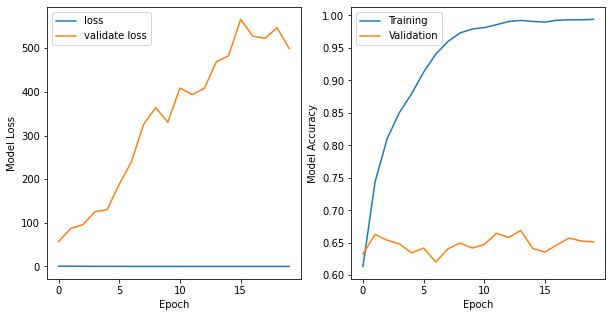

In [ ]:
fs, axs = plt.subplots(1,2, figsize = (10,5))

axs[0].plot(history_second.history['loss'], label = 'loss')
axs[0].plot(history_second.history['val_loss'], label = 'validate loss') #code taken from tutorial 8 modified
axs[0].set_ylabel('Model Loss')
axs[0].set_xlabel('Epoch')

axs[1].plot(history_second.history['accuracy'], label = 'Training')
axs[1].plot(history_second.history['val_accuracy'], label = 'Validation')
axs[1].set_ylabel('Model Accuracy')
axs[1].set_xlabel('Epoch')


axs[0].legend()
plt.legend()
plt.show()